In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
import numpy as np
import pandas as pd
import os
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import normalize
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(os.path.join(DATA_PATH,'BOD_biclass_139rdkit.csv'))
data_139 = data.iloc[:,2:141]
data_train = data_139.values
data_train.shape
data_train = normalize(data_train, axis=0, order=2)

(array([419.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 644.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

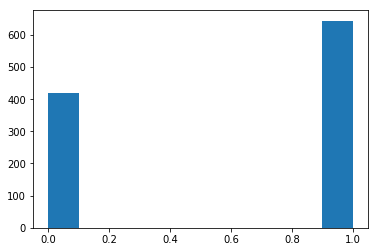

In [3]:
true_label_biclass = data['bod_class'].values
plt.hist(true_label_biclass)

In [4]:
from dimreducer import DeepAutoEncoder
from cluster import KMeansLayer
from keras import Model

In [5]:
dims = [139,100,70,50]
autoencoder = DeepAutoEncoder(dims)
autoencoder.build_autoencoder()
autoencoder.model.summary()

AttributeError: 'DeepAutoEncoder' object has no attribute 'build_autoencoder'

In [ ]:
embeding   = autoencoder.model.get_layer(name='embedding_layer').output
encoder    = Model(inputs=autoencoder.model.input, outputs=embeding)
n_clusters = 2
alpha      = 1.0
clustering = KMeansLayer(n_clusters, alpha=alpha, name='clustering')(embeding)
model      = Model(inputs=autoencoder.model.input, outputs=[clustering,autoencoder.model.output])

In [ ]:
model.summary()

In [ ]:
model.compile(loss={'clustering': 'kld', 'decoder_output': 'mse'},
              loss_weights=[0.05, 1],optimizer='adam')

In [ ]:
from cluster import KMeans

def target_distribution(q):  # target distribution P which enhances the discrimination of soft label Q
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
kmeans_init = KMeans(n_clusters=2)
kmeans_init.bulid_kmeans_cluster()
kmeans_init.model.fit(encoder.predict(data_train))
y_pred_last = kmeans_init.model.labels_
model.get_layer(name='clustering').set_weights([kmeans_init.model.cluster_centers_])

In [ ]:
plt.hist(y_pred_last)

In [ ]:
update_interval = 50
maxiter = 1e4
tol = 1e-4
loss = []
delta_label = []
for iteration in range(int(maxiter)):
    if iteration % update_interval == 0:
        q, _ = model.predict(data_train)
        p = target_distribution(q)
        y_pred = q.argmax(1)
        delta_label_i = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        delta_label.append(delta_label_i)
        y_pred_last = y_pred
    
    if iteration > 50 and delta_label_i < tol:  
        print(str(delta_label_i) +' < ' + str(tol))
        print('Reached tolerance threshold. Stopping training.')
        break
    
    loss_tmp = model.train_on_batch(x=data_train, y=[p,data_train])
    loss.append(loss_tmp)
    if iteration % update_interval == 0:
        print('Epoch: ' + str(iteration))
        print('total_loss = ' + str(loss_tmp[0]) + '; clustering_loss = ' +
              str(loss_tmp[1]) + '; decoder_loss = ' + str(loss_tmp[2]) + 
              '; delta_label = ' + str(delta_label_i))
    



In [ ]:
plt.plot(loss)

In [ ]:
plt.plot(delta_label)

In [ ]:
plt.hist(y_pred)

In [ ]:
from cluster import KMeans
KMeans.true_label_metrics(true_label_biclass,y_pred,print_metric=True)

In [ ]:
np.count_nonzero(true_label_biclass == y_pred)